In [2]:
#import libraries
import os
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import librosa
import librosa.display

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense, Concatenate
from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
import keras.backend as K
from keras.metrics import Precision, Recall

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, AveragePooling2D, Dropout, Flatten, Dense, Softmax, Concatenate, MaxPooling2D

import keras
from keras import backend as K
from keras.layers import Input, Conv2D, BatchNormalization, Dropout, AveragePooling2D, Flatten, Dense, MaxPooling2D, Concatenate
from keras.models import Model
from keras.metrics import Precision, Recall
from sklearn.model_selection import KFold
import numpy as np

**Step 1: Preprocessing Soundtracks & 4Q datasets**

In [4]:
# Assuming 'Set1.zip' is in the current directory
with zipfile.ZipFile('c:\\Users\\josep\\Downloads\\Set1.zip', 'r') as zip_ref:
    zip_ref.extractall('Set1')

# Now 'Set1' directory contains the unzipped audio files
Soundtracks_dataset_path = 'Set1'

In [8]:
# Load the CSV with ratings
ratings_df = pd.read_csv('C:\\Users\\josep\\Downloads\\mean_ratings_set1.csv')

In [9]:
def preprocess_audio(file_path, sr=44100, n_mels=128, duration=6):
    try:
        # Load the audio file (supports .mp3 format)
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure the audio length is 6 seconds
        if len(y) < duration * sr:
            padding = duration * sr - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # Short-Time Fourier Transform (STFT) with specified parameters
        stft = librosa.stft(y, n_fft=2048, hop_length=512, window='hann')
        stft_db = librosa.amplitude_to_db(abs(stft))
        
        # Convert STFT to Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=16384)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Adjust the dB scale by adding 20 dB
        mel_spectrogram_db += 20
        
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def get_label_from_filename(filename, ratings_df):
    # Extract the number from the filename
    number = int(filename.split('.')[0].split('_')[-1])
    
    # Find the corresponding row in the DataFrame
    row = ratings_df[ratings_df['number'] == number]
    
    if row.empty:
        raise ValueError(f"No match found in ratings_df for number: {number}")
    
    # Extract valence and arousal
    valence = row['valence'].values[0]
    arousal = row['energy'].values[0]
    
    # Print for debugging
    print(f"Filename: {filename}, Number: {number}, Valence: {valence}, Arousal: {arousal}")
    
    # Determine the quadrant
    if valence > 4 and arousal > 4:
        return 0  # Q1 (exuberance)
    elif valence <= 4 and arousal > 4:
        return 1  # Q2 (anxiety)
    elif valence <= 4 and arousal <= 4:
        return 2  # Q3 (depression)
    elif valence > 4 and arousal <= 4:
        return 3  # Q4 (contentment)
    else:
        raise ValueError("Invalid valence or arousal value")

def load_dataset(dataset_path, ratings_df):
    """
    Load and preprocess dataset.

    Args:
        dataset_path (str): Path to the dataset folder containing audio files.
        ratings_df (DataFrame): DataFrame containing ratings for each file.

    Returns:
        X (list): List of mel spectrograms.
        y (list): List of labels.
    """
    X = []
    y = []

    # Gather all files and sort them numerically
    files = []
    for root, _, filenames in os.walk(dataset_path):
        for file in filenames:
            if file.endswith('.mp3') and not file.startswith('._'):  # Check for .mp3 files and ignore macOS hidden files
                files.append(os.path.join(root, file))
    files.sort(key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

    # Process each file in the sorted order
    for file_path in files:
        mel_spectrogram = preprocess_audio(file_path)
        if mel_spectrogram is not None:
            label = get_label_from_filename(os.path.basename(file_path), ratings_df)  # Use updated label extraction logic
            X.append(mel_spectrogram)
            y.append(label)
    
    return X, y

def plot_mel_spectrogram(mel_spectrogram, sr=22050):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=16384, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB', ticks=[-40, -20, 0, 20])
    plt.title('Mel Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.show()

In [10]:
"""# Load the CSV with ratings
ratings_df = pd.read_csv('/Users/lindarcourt/Downloads/mean_ratings_set1.csv')

# Print the first five rows of the CSV
print(ratings_df.head())"""

# Example usage for the extracted dataset
Soundtracks_dataset_path = 'Set1'
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Confirm labels are correctly assigned
print(y_Soundtracks[:5])



Filename: 001.mp3, Number: 1, Valence: 4.83, Arousal: 6.83
Filename: 002.mp3, Number: 2, Valence: 4.83, Arousal: 6.17
Filename: 003.mp3, Number: 3, Valence: 5.6, Arousal: 6.2
Filename: 004.mp3, Number: 4, Valence: 4.67, Arousal: 6.33
Filename: 005.mp3, Number: 5, Valence: 6.5, Arousal: 5.0
Filename: 006.mp3, Number: 6, Valence: 5.0, Arousal: 5.4
Filename: 007.mp3, Number: 7, Valence: 5.4, Arousal: 6.2
Filename: 008.mp3, Number: 8, Valence: 5.0, Arousal: 5.2
Filename: 009.mp3, Number: 9, Valence: 6.0, Arousal: 6.0
Filename: 010.mp3, Number: 10, Valence: 4.83, Arousal: 6.17
Filename: 011.mp3, Number: 11, Valence: 4.83, Arousal: 6.5
Filename: 012.mp3, Number: 12, Valence: 5.2, Arousal: 6.8
Filename: 013.mp3, Number: 13, Valence: 5.83, Arousal: 5.83
Filename: 014.mp3, Number: 14, Valence: 5.2, Arousal: 6.0
Filename: 015.mp3, Number: 15, Valence: 5.83, Arousal: 4.17
Filename: 016.mp3, Number: 16, Valence: 6.0, Arousal: 3.4
Filename: 017.mp3, Number: 17, Valence: 5.67, Arousal: 4.5
Filename:

Number of samples in X: 360
Number of labels in y: 360
Lengths of X and y match.
Shape of mel spectrogram 0: (128, 517)
Label 0: 0
Shape of mel spectrogram 1: (128, 517)
Label 1: 0
Shape of mel spectrogram 2: (128, 517)
Label 2: 0


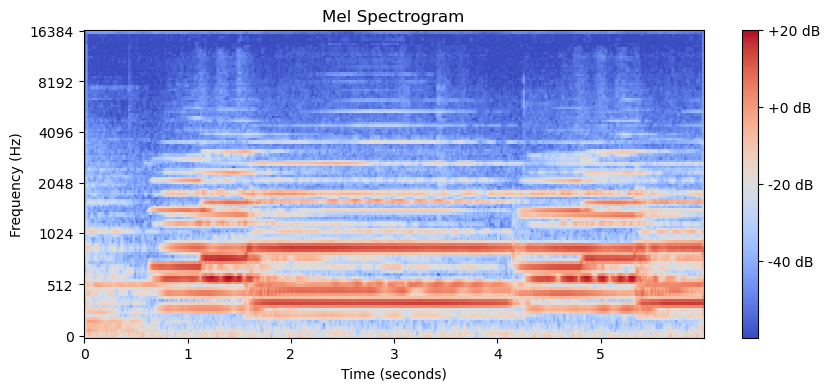

In [11]:
# Check the lengths of X and y
print(f"Number of samples in X: {len(X_Soundtracks)}")
print(f"Number of labels in y: {len(y_Soundtracks)}")

# Ensure that the lengths match
if len(X_Soundtracks) == len(y_Soundtracks):
    print("Lengths of X and y match.")
else:
    print("Mismatch in lengths of X and y.")

# Inspect the shape of the first few mel spectrograms
for i in range(3):
    print(f"Shape of mel spectrogram {i}: {X_Soundtracks[i].shape}")
    print(f"Label {i}: {y_Soundtracks[i]}")


# Test with a sample mel spectrogram
plot_mel_spectrogram(X_Soundtracks[50], sr=44100)

In [ ]:
"""X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path)
X_4q, y_4q = load_dataset(fourq_dataset_path)

# Convert lists to numpy arrays and reshape for the model
X_soundtracks = np.array(X_soundtracks).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary
X_4q = np.array(X_4q).reshape(-1, 128, 862, 1)  # Adjust the shape as necessary"""

**Step 3: Defining model filters**

In [37]:
# Define the fundamental frequencies for each pitch class
pitch_classes = {
    'C': 16.35,
    'C#': 17.32,
    'D': 18.35,
    'D#': 19.45,
    'E': 20.60,
    'F': 21.83,
    'F#': 23.12,
    'G': 24.50,
    'G#': 25.96,
    'A': 27.50,
    'A#': 29.14,
    'B': 30.87
}

def create_pitch_class_blinders(fundamental_freq, filter_type, n_bands):
    frequencies = []
    if filter_type == 'harmonics':
        frequencies = [n * fundamental_freq for n in range(1, n_bands + 1)]
    elif filter_type == 'octaves':
        frequencies = [2**n * fundamental_freq for n in range(n_bands)]
    elif filter_type == 'fifths':
        frequencies = [(3/2)**n * fundamental_freq for n in range(n_bands)]
    else:
        raise ValueError("Unknown filter type")

    # Construct the STFT indicator column
    stft_bins = np.linspace(0, 22050, 1025)  # assuming sampling rate is 44100
    stft_indicator = np.zeros_like(stft_bins)
    
    for freq in frequencies:
        idx = np.argmin(np.abs(stft_bins - freq))
        stft_indicator[idx] = 1
    
    # Convert the STFT indicator column to mel blinders
    mel_bins = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=22050)
    mel_blinders = np.dot(stft_indicator, librosa.filters.mel(sr=44100, n_fft=2048, n_mels=128).T)
    
    return mel_blinders

def create_consonance_filter(input_layer, filter_type, num_bands):
    blinders_list = []
    for pitch, fundamental_freq in pitch_classes.items():
        blinders = create_pitch_class_blinders(fundamental_freq, filter_type, num_bands)
        blinders_list.append(blinders)
    
    blinders_stack = np.stack(blinders_list, axis=-1)
    blinders_tensor = tf.convert_to_tensor(blinders_stack, dtype=tf.float32)
    
    # Expand dimensions to match input layer
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=1)
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=0)
    blinders_tensor = tf.expand_dims(blinders_tensor, axis=-1)  # Add channel dimension
    
    # Apply the mel blinders to the input
    filtered_inputs = []
    for i in range(blinders_tensor.shape[-2]):  # Adjust for pitch class dimension
        filtered_input = tf.multiply(input_layer, blinders_tensor[..., i, :])
        
        # Convolution layer to capture the relevant features
        conv = Conv2D(32, (128, 1), strides=(1, 1), activation='relu', padding='same')(filtered_input)
        conv = BatchNormalization()(conv)
        conv = ReLU()(conv)
        pooled = AveragePooling2D(pool_size=(1, 517))(conv)
        pooled = Dropout(0.5)(pooled)
        filtered_inputs.append(pooled)
    
    return filtered_inputs

def create_model_with_consonance_filters(input_shape, filter_type, num_bands):
    input_layer = Input(shape=input_shape)

    # Add an extra dimension for the channel
    expanded_input_layer = tf.expand_dims(input_layer, axis=-1)

    # Apply the specified consonance filter
    filter_outputs = create_consonance_filter(expanded_input_layer, filter_type, num_bands)

    # Concatenate the outputs of the pitch classes
    concatenated = Concatenate()(filter_outputs)

    # Max pooling and further layers as per the article
    x = MaxPooling2D(pool_size=(12, 1))(concatenated)
    x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(32 * 16, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(16 * 4, activation='relu')(x)
    output_layer = Dense(4, activation='softmax')(x)  # 4 quadrants for valence-arousal

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])
    return model


In [ ]:
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [39]:
# Define the input shape
input_shape = (128, 517)

# Create the model with harmonics filter
harmonics_model = create_model_with_consonance_filters(input_shape, 'harmonics', 1400)
harmonics_model.summary()

# Create the model with octaves filter
octaves_model = create_model_with_consonance_filters(input_shape, 'octaves', 11)
octaves_model.summary()

# Create the model with fifths filter
fifths_model = create_model_with_consonance_filters(input_shape, 'fifths', 20)
fifths_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 128, 517)]           0         []                            
                                                                                                  
 tf.expand_dims_25 (TFOpLam  (None, 128, 517, 1)          0         ['input_26[0][0]']            
 bda)                                                                                             
                                                                                                  
 tf.math.multiply_300 (TFOp  (None, 128, 517, 1)          0         ['tf.expand_dims_25[0][0]']   
 Lambda)                                                                                          
                                                                                           

In [ ]:
"""
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])

In [ ]:
# Evaluate CNN with Square Filters
avg_accuracy_square, avg_precision_square, avg_f1_square = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_square_filter_model)
print(f"Square Filter CNN - Accuracy: {avg_accuracy_square}, Precision: {avg_precision_square}, F1-Score: {avg_f1_square}")

# Evaluate CNN with Time Filters
avg_accuracy_time, avg_precision_time, avg_f1_time = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_filter_model)
print(f"Time Filter CNN - Accuracy: {avg_accuracy_time}, Precision: {avg_precision_time}, F1-Score: {avg_f1_time}")

# Evaluate CNN with Frequency Filters
avg_accuracy_frequency, avg_precision_frequency, avg_f1_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_frequency_filter_model)
print(f"Frequency Filter CNN - Accuracy: {avg_accuracy_frequency}, Precision: {avg_precision_frequency}, F1-Score: {avg_f1_frequency}")

# Evaluate CNN with Time and Frequency Filters
avg_accuracy_time_frequency, avg_precision_time_frequency, avg_f1_time_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_frequency_filter_model)
print(f"Time and Frequency Filter CNN - Accuracy: {avg_accuracy_time_frequency}, Precision: {avg_precision_time_frequency}, F1-Score: {avg_f1_time_frequency}")


Epoch 1/30


KeyboardInterrupt: 

In [ ]:
# Evaluate CNN with Square Filters
avg_accuracy_square, avg_precision_square, avg_f1_square = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_square_filter_model)
print(f"Square Filter CNN - Accuracy: {avg_accuracy_square}, Precision: {avg_precision_square}, F1-Score: {avg_f1_square}")

# Evaluate CNN with Time Filters
avg_accuracy_time, avg_precision_time, avg_f1_time = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_filter_model)
print(f"Time Filter CNN - Accuracy: {avg_accuracy_time}, Precision: {avg_precision_time}, F1-Score: {avg_f1_time}")

# Evaluate CNN with Frequency Filters
avg_accuracy_frequency, avg_precision_frequency, avg_f1_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_frequency_filter_model)
print(f"Frequency Filter CNN - Accuracy: {avg_accuracy_frequency}, Precision: {avg_precision_frequency}, F1-Score: {avg_f1_frequency}")

# Evaluate CNN with Time and Frequency Filters
avg_accuracy_time_frequency, avg_precision_time_frequency, avg_f1_time_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_frequency_filter_model)
print(f"Time and Frequency Filter CNN - Accuracy: {avg_accuracy_time_frequency}, Precision: {avg_precision_time_frequency}, F1-Score: {avg_f1_time_frequency}")


Epoch 1/30


KeyboardInterrupt: 

**Step 4 Model performance, Incorporating benchmark models**

**Updated code for evaluation: SVM model**

In [45]:
# Extract MFCC features
def extract_mfcc_features(file_path, sr=44100, n_mfcc=13, duration=6):
    try:
        # Load the audio file (supports .mp3 format)
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure the audio length is 6 seconds
        if len(y) < duration * sr:
            padding = duration * sr - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Combine MFCC and its deltas
        mfcc_features = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
        
        return mfcc_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset_mfcc(dataset_path, ratings_df):
    X = []
    y = []

    # Gather all files and sort them numerically
    files = []
    for root, _, filenames in os.walk(dataset_path):
        for file in filenames:
            if file.endswith('.mp3') and not file.startswith('._'):  # Check for .mp3 files and ignore macOS hidden files
                files.append(os.path.join(root, file))
    files.sort(key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

    # Process each file in the sorted order
    for file_path in files:
        mfcc_features = extract_mfcc_features(file_path)
        if mfcc_features is not None:
            label = get_label_from_filename(os.path.basename(file_path), ratings_df)
            X.append(mfcc_features)
            y.append(label)

    return np.array(X), np.array(y)


In [46]:
def evaluate_svm_model(X, y, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
        svm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
        y_pred = svm_model.predict(X_val.reshape(X_val.shape[0], -1))

        precision = precision_score(y_val, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_val, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1

In [47]:
# Load the dataset with MFCC features
Soundtracks_dataset_path = 'Set1'
ratings_df = pd.read_csv('C:\\Users\\josep\\Downloads\\mean_ratings_set1.csv') # Ensure the ratings DataFrame is loaded correctly
X_mfcc_Soundtracks, y_mfcc_Soundtracks = load_dataset_mfcc(Soundtracks_dataset_path, ratings_df)

# Confirm labels are correctly assigned
print(y_mfcc_Soundtracks[:5])

Filename: 001.mp3, Number: 1, Valence: 4.83, Arousal: 6.83
Filename: 002.mp3, Number: 2, Valence: 4.83, Arousal: 6.17
Filename: 003.mp3, Number: 3, Valence: 5.6, Arousal: 6.2
Filename: 004.mp3, Number: 4, Valence: 4.67, Arousal: 6.33
Filename: 005.mp3, Number: 5, Valence: 6.5, Arousal: 5.0
Filename: 006.mp3, Number: 6, Valence: 5.0, Arousal: 5.4
Filename: 007.mp3, Number: 7, Valence: 5.4, Arousal: 6.2
Filename: 008.mp3, Number: 8, Valence: 5.0, Arousal: 5.2
Filename: 009.mp3, Number: 9, Valence: 6.0, Arousal: 6.0
Filename: 010.mp3, Number: 10, Valence: 4.83, Arousal: 6.17
Filename: 011.mp3, Number: 11, Valence: 4.83, Arousal: 6.5
Filename: 012.mp3, Number: 12, Valence: 5.2, Arousal: 6.8
Filename: 013.mp3, Number: 13, Valence: 5.83, Arousal: 5.83
Filename: 014.mp3, Number: 14, Valence: 5.2, Arousal: 6.0
Filename: 015.mp3, Number: 15, Valence: 5.83, Arousal: 4.17
Filename: 016.mp3, Number: 16, Valence: 6.0, Arousal: 3.4
Filename: 017.mp3, Number: 17, Valence: 5.67, Arousal: 4.5
Filename:

In [48]:
# Evaluate SVM with MFCC features
avg_precision_svm, avg_recall_svm, avg_f1_svm = evaluate_svm_model(X_mfcc_Soundtracks, y_mfcc_Soundtracks)
print(f"SVM with MFCC - Precision: {avg_precision_svm}, Recall: {avg_recall_svm}, F1-Score: {avg_f1_svm}")

SVM with MFCC - Precision: 0.543074652505122, Recall: 0.5388888888888889, F1-Score: 0.51374545759037


**Updated code for evaluation: CNN Models (Square, Time, Frequency, and Time-Frequency Filters)**


In [49]:
class F1Score(keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [30]:
"""def f1_score(y_true, y_pred):
    precision = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())
    recall = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))""""

In [50]:
def create_square_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    for _ in range(8):  # Adding 8 more convolutional layers as described
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
    
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)  # Additional fully connected layer
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])
    return model

def create_time_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Time filter (short and wide)
    time_filter = Conv2D(32, (1, 10), activation='relu', padding='same')(input_layer)
    time_filter = BatchNormalization()(time_filter)
    time_filter = Dropout(0.5)(time_filter)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(time_filter)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])
    return model

def create_frequency_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Frequency filter (tall and skinny)
    frequency_filter = Conv2D(32, (10, 1), activation='relu', padding='same')(input_layer)
    frequency_filter = BatchNormalization()(frequency_filter)
    frequency_filter = Dropout(0.5)(frequency_filter)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(frequency_filter)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])
    return model

def create_time_frequency_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Time filters (short and wide)
    time_filter = Conv2D(32, (1, 10), activation='relu', padding='same')(input_layer)
    time_filter = BatchNormalization()(time_filter)
    time_filter = Dropout(0.5)(time_filter)
    
    # Frequency filters (tall and skinny)
    frequency_filter = Conv2D(32, (10, 1), activation='relu', padding='same')(input_layer)
    frequency_filter = BatchNormalization()(frequency_filter)
    frequency_filter = Dropout(0.5)(frequency_filter)
    
    # Combine both filters
    combined_filters = Concatenate()([time_filter, frequency_filter])
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(combined_filters)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)  # Additional fully connected layer
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy', Precision(name='precision'), F1Score(name='f1_score')])
    return model



In [51]:
def evaluate_cnn_model(X, y, model_function, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Add channel dimension for CNN input
        X_train = np.expand_dims(X_train, axis=-1)
        X_val = np.expand_dims(X_val, axis=-1)

        model = model_function(X_train.shape[1:])
        model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

        metrics = model.evaluate(X_val, y_val, verbose=0)
        accuracy = metrics[model.metrics_names.index('accuracy')]
        precision = metrics[model.metrics_names.index('precision')]
        f1 = metrics[model.metrics_names.index('f1_score')]

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        f1_scores.append(f1)

    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_accuracy, avg_precision, avg_f1

In [52]:
# In case kernel forgot, set X and y again
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Convert labels to categorical format for CNN models
y_Soundtracks_categorical = to_categorical(y_Soundtracks, num_classes=4)
# Convert X_Soundtracks to numpy array
X_Soundtracks = np.array(X_Soundtracks)


Filename: 001.mp3, Number: 1, Valence: 4.83, Arousal: 6.83
Filename: 002.mp3, Number: 2, Valence: 4.83, Arousal: 6.17
Filename: 003.mp3, Number: 3, Valence: 5.6, Arousal: 6.2
Filename: 004.mp3, Number: 4, Valence: 4.67, Arousal: 6.33
Filename: 005.mp3, Number: 5, Valence: 6.5, Arousal: 5.0
Filename: 006.mp3, Number: 6, Valence: 5.0, Arousal: 5.4
Filename: 007.mp3, Number: 7, Valence: 5.4, Arousal: 6.2
Filename: 008.mp3, Number: 8, Valence: 5.0, Arousal: 5.2
Filename: 009.mp3, Number: 9, Valence: 6.0, Arousal: 6.0
Filename: 010.mp3, Number: 10, Valence: 4.83, Arousal: 6.17
Filename: 011.mp3, Number: 11, Valence: 4.83, Arousal: 6.5
Filename: 012.mp3, Number: 12, Valence: 5.2, Arousal: 6.8
Filename: 013.mp3, Number: 13, Valence: 5.83, Arousal: 5.83
Filename: 014.mp3, Number: 14, Valence: 5.2, Arousal: 6.0
Filename: 015.mp3, Number: 15, Valence: 5.83, Arousal: 4.17
Filename: 016.mp3, Number: 16, Valence: 6.0, Arousal: 3.4
Filename: 017.mp3, Number: 17, Valence: 5.67, Arousal: 4.5
Filename:

In [91]:
# Evaluate CNN with Square Filters
avg_accuracy_square, avg_precision_square, avg_f1_square = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_square_filter_model)
print(f"Square Filter CNN - Accuracy: {avg_accuracy_square}, Precision: {avg_precision_square}, F1-Score: {avg_f1_square}")

# Evaluate CNN with Time Filters
avg_accuracy_time, avg_precision_time, avg_f1_time = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_filter_model)
print(f"Time Filter CNN - Accuracy: {avg_accuracy_time}, Precision: {avg_precision_time}, F1-Score: {avg_f1_time}")

# Evaluate CNN with Frequency Filters
avg_accuracy_frequency, avg_precision_frequency, avg_f1_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_frequency_filter_model)
print(f"Frequency Filter CNN - Accuracy: {avg_accuracy_frequency}, Precision: {avg_precision_frequency}, F1-Score: {avg_f1_frequency}")

# Evaluate CNN with Time and Frequency Filters
avg_accuracy_time_frequency, avg_precision_time_frequency, avg_f1_time_frequency = evaluate_cnn_model(X_Soundtracks, y_Soundtracks_categorical, create_time_frequency_filter_model)
print(f"Time and Frequency Filter CNN - Accuracy: {avg_accuracy_time_frequency}, Precision: {avg_precision_time_frequency}, F1-Score: {avg_f1_time_frequency}")


Epoch 1/30


KeyboardInterrupt: 

***Older code**

In [81]:
def evaluate_model(X, y, model_function, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = [X[i] for i in train_index], [X[i] for i in val_index]
        y_train, y_val = [y[i] for i in train_index], [y[i] for i in val_index]

        X_train = np.expand_dims(np.array(X_train), axis=-1)
        X_val = np.expand_dims(np.array(X_val), axis=-1)

        y_train = np.array(y_train)
        y_val = np.array(y_val)

        model = model_function(X_train.shape[1:])
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)

        precision = precision_score(y_val, y_pred_classes, average='weighted')
        recall = recall_score(y_val, y_pred_classes, average='weighted')
        f1 = f1_score(y_val, y_pred_classes, average='weighted')

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)

    return avg_precision, avg_recall, avg_f1


Atheoretical: SVM with MFCC's:

In [82]:
# Extract MFCC features
def extract_mfcc_features(file_path, sr=44100, n_mfcc=13, duration=6):
    try:
        # Load the audio file (supports .mp3 format)
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        
        # Ensure the audio length is 6 seconds
        if len(y) < duration * sr:
            padding = duration * sr - len(y)
            y = np.pad(y, (0, padding), 'constant')
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc)
        mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Combine MFCC and its deltas
        mfcc_features = np.vstack([mfcc, mfcc_delta, mfcc_delta2])
        
        return mfcc_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset_mfcc(dataset_path, ratings_df):
    X = []
    y = []

    # Gather all files and sort them numerically
    files = []
    for root, _, filenames in os.walk(dataset_path):
        for file in filenames:
            if file.endswith('.mp3') and not file.startswith('._'):  # Check for .mp3 files and ignore macOS hidden files
                files.append(os.path.join(root, file))
    files.sort(key=lambda x: int(os.path.basename(x).split('.')[0].split('_')[-1]))

    # Process each file in the sorted order
    for file_path in files:
        mfcc_features = extract_mfcc_features(file_path)
        if mfcc_features is not None:
            label = get_label_from_filename(os.path.basename(file_path), ratings_df)
            X.append(mfcc_features)
            y.append(label)

    return np.array(X), np.array(y)


In [88]:
"""# Load the CSV with ratings
ratings_df = pd.read_csv('/Users/lindarcourt/Downloads/mean_ratings_set1.csv')

# Print the first five rows of the CSV
print(ratings_df.head())"""


# Load MFCC dataset
Soundtracks_dataset_path = 'Set1'
ratings_df = pd.read_csv('/Users/lindarcourt/Downloads/mean_ratings_set1.csv') 
X_mfcc_Soundtracks, y_mfcc_Soundtracks = load_dataset_mfcc(Soundtracks_dataset_path, ratings_df)

# Confirm labels are correctly assigned
print(y_mfcc_Soundtracks[:5])

Filename: 001.mp3, Number: 1, Valence: 4.83, Arousal: 6.83
Filename: 002.mp3, Number: 2, Valence: 4.83, Arousal: 6.17
Filename: 003.mp3, Number: 3, Valence: 5.6, Arousal: 6.2
Filename: 004.mp3, Number: 4, Valence: 4.67, Arousal: 6.33
Filename: 005.mp3, Number: 5, Valence: 6.5, Arousal: 5.0
Filename: 006.mp3, Number: 6, Valence: 5.0, Arousal: 5.4
Filename: 007.mp3, Number: 7, Valence: 5.4, Arousal: 6.2
Filename: 008.mp3, Number: 8, Valence: 5.0, Arousal: 5.2
Filename: 009.mp3, Number: 9, Valence: 6.0, Arousal: 6.0
Filename: 010.mp3, Number: 10, Valence: 4.83, Arousal: 6.17
Filename: 011.mp3, Number: 11, Valence: 4.83, Arousal: 6.5
Filename: 012.mp3, Number: 12, Valence: 5.2, Arousal: 6.8
Filename: 013.mp3, Number: 13, Valence: 5.83, Arousal: 5.83
Filename: 014.mp3, Number: 14, Valence: 5.2, Arousal: 6.0
Filename: 015.mp3, Number: 15, Valence: 5.83, Arousal: 4.17
Filename: 016.mp3, Number: 16, Valence: 6.0, Arousal: 3.4
Filename: 017.mp3, Number: 17, Valence: 5.67, Arousal: 4.5
Filename:

In [ ]:
# Set variables with mfcc + train and test split
X_train_mfcc, X_val_mfcc, y_train_mfcc, y_val_mfcc = train_test_split(X_mfcc_Soundtracks, y_mfcc_Sound, test_size=0.2, random_state=42)

# Create and train SVM model
svm_model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_model.fit(X_train_mfcc.reshape(X_train_mfcc.shape[0], -1), y_train_mfcc)

In [ ]:
# Predict on the validation set
y_pred_mfcc = svm_model.predict(X_val_mfcc.reshape(X_val_mfcc.shape[0], -1))

# Calculate accuracy, precision, and F1-score
svm_accuracy = accuracy_score(y_val_mfcc, y_pred_mfcc)
svm_precision = precision_score(y_val_mfcc, y_pred_mfcc, average='weighted')
svm_f1 = f1_score(y_val_mfcc, y_pred_mfcc, average='weighted')

print(f"SVM with MFCC Validation Accuracy: {svm_accuracy}")
print(f"SVM with MFCC Validation Precision: {svm_precision}")
print(f"SVM with MFCC Validation F1-Score: {svm_f1}")

Atheoretical: CNN with Square Filters:

In [90]:
# Function to create square filter model
def create_square_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    for _ in range(8):  # Adding 8 more convolutional layers as described
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
    
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)                                                                                        
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)  # Additional fully connected layer
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# In case kernel forgot, set X and y again
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_Soundtracks, y_Soundtracks, test_size=0.2, random_state=42)

# Ensure the labels are in categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [ ]:
    # Convert labels to categorical format for CNN models
    y_Soundtracks_categorical = to_categorical(y_Soundtracks, num_classes=4)

    # Ensure the input shape is compatible with the CNN models
    input_shape = X_train.shape[1:] + (1,)
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
# Create and compile the model with square filters
square_filter_model = create_square_filter_model(input_shape)
square_filter_model.summary()

In [ ]:
# Train the model with square filters
history_square = square_filter_model.fit(np.expand_dims(X_train, -1), y_train, epochs=30, batch_size=32, validation_data=(np.expand_dims(X_val, -1), y_val))

In [ ]:
# Evaluate the model with square filters with accuracy, prediction and F-1 scores
val_loss_square, val_accuracy_square = square_filter_model.evaluate(np.expand_dims(X_val, -1), y_val)

y_val_pred_square = square_filter_model.predict(np.expand_dims(X_val, -1))
y_val_pred_labels_square = np.argmax(y_val_pred_square, axis=1)
y_val_true_labels = np.argmax(y_val, axis=1)

precision_square = precision_score(y_val_true_labels, y_val_pred_labels_square, average='weighted')
f1_square = f1_score(y_val_true_labels, y_val_pred_labels_square, average='weighted')

print(f"Square Filter CNN Validation Accuracy: {val_accuracy_square}")
print(f"Square Filter CNN Validation Precision: {precision_square}")
print(f"Square Filter CNN Validation F1-Score: {f1_square}")

Low-level theoretical: CNN with time filter

In [ ]:
def create_time_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Time filter (short and wide)
    time_filter = Conv2D(32, (1, 10), activation='relu', padding='same')(input_layer)
    time_filter = BatchNormalization()(time_filter)
    time_filter = Dropout(0.5)(time_filter)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(time_filter)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'F1Score'])
    return model

In [ ]:
# In case kernel forgot, set X and y again
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_Soundtracks, y_Soundtracks, test_size=0.2, random_state=42)

# Ensure the labels are in categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [ ]:
# Convert labels to categorical format for CNN models
y_Soundtracks_categorical = to_categorical(y_Soundtracks, num_classes=4)

# Ensure the input shape is compatible with the CNN models
input_shape = X_train.shape[1:] + (1,)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
# Create and compile the model with time filters
time_filter_model = create_time_filter_model(input_shape)
time_filter_model.summary()

In [ ]:
# Train the model with time filters
history_time_filter = time_filter_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Evaluate the model with time filters
val_loss_time_filter, val_accuracy_time_filter, val_precision_time_filter, val_f1_time_filter = time_filter_model.evaluate(X_val, y_val)
print(f"Time Filter CNN Validation Accuracy: {val_accuracy_time_filter}")
print(f"Time Filter CNN Validation Precision: {val_precision_time_filter}")
print(f"Time Filter CNN Validation F1-Score: {val_f1_time_filter}")

Low-level theoretical: CNN with frequency filter

In [ ]:
def create_frequency_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Frequency filter (tall and skinny)
    frequency_filter = Conv2D(32, (10, 1), activation='relu', padding='same')(input_layer)
    frequency_filter = BatchNormalization()(frequency_filter)
    frequency_filter = Dropout(0.5)(frequency_filter)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(frequency_filter)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'F1Score'])
    return model



In [ ]:
# In case kernel forgot, set X and y again
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_Soundtracks, y_Soundtracks, test_size=0.2, random_state=42)

# Ensure the labels are in categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [ ]:
# Convert labels to categorical format for CNN models
y_Soundtracks_categorical = to_categorical(y_Soundtracks, num_classes=4)

# Ensure the input shape is compatible with the CNN models
input_shape = X_train.shape[1:] + (1,)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
# Create and compile the model with frequency filters
frequency_filter_model = create_frequency_filter_model(input_shape)
frequency_filter_model.summary()

In [ ]:
# Train the model with frequency filters
history_frequency_filter = frequency_filter_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

In [ ]:
# Evaluate the model with frequency filters
val_loss_frequency_filter, val_accuracy_frequency_filter, val_precision_frequency_filter, val_f1_frequency_filter = frequency_filter_model.evaluate(X_val, y_val)
print(f"Frequency Filter CNN Validation Accuracy: {val_accuracy_frequency_filter}")
print(f"Frequency Filter CNN Validation Precision: {val_precision_frequency_filter}")
print(f"Frequency Filter CNN Validation F1-Score: {val_f1_frequency_filter}")

Low-level theoretical: CNN with time and frequency filters

In [ ]:
# Function to create time and frequency filter model
def create_time_frequency_filter_model(input_shape):
    input_layer = Input(shape=input_shape)

    # Time filters (short and wide)
    time_filter = Conv2D(32, (1, 10), activation='relu', padding='same')(input_layer)
    time_filter = BatchNormalization()(time_filter)
    time_filter = Dropout(0.5)(time_filter)
    
    # Frequency filters (tall and skinny)
    frequency_filter = Conv2D(32, (10, 1), activation='relu', padding='same')(input_layer)
    frequency_filter = BatchNormalization()(frequency_filter)
    frequency_filter = Dropout(0.5)(frequency_filter)
    
    # Combine both filters
    combined_filters = Concatenate()([time_filter, frequency_filter])
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(combined_filters)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)  # Additional fully connected layer
    x = Dropout(0.5)(x)
    output_layer = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# In case kernel forgot, set X and y again
X_Soundtracks, y_Soundtracks = load_dataset(Soundtracks_dataset_path, ratings_df)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_Soundtracks, y_Soundtracks, test_size=0.2, random_state=42)

# Ensure the labels are in categorical format
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [ ]:
# Convert labels to categorical format for CNN models
y_Soundtracks_categorical = to_categorical(y_Soundtracks, num_classes=4)

# Ensure the input shape is compatible with the CNN models
input_shape = X_train.shape[1:] + (1,)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

In [ ]:
# Create and compile the model with time and frequency filters
time_frequency_filter_model = create_time_frequency_filter_model(input_shape)
time_frequency_filter_model.summary()

In [ ]:
# Train the model with time and frequency filters
history_time_frequency = time_frequency_filter_model.fit(np.expand_dims(X_train, -1), y_train, epochs=30, batch_size=32, validation_data=(np.expand_dims(X_val, -1), y_val))

In [ ]:
# Evaluate the model with time and frequency filters
val_loss_time_frequency, val_accuracy_time_frequency = time_frequency_filter_model.evaluate(np.expand_dims(X_val, -1), y_val)
y_val_pred_time_frequency = time_frequency_filter_model.predict(np.expand_dims(X_val, -1))
y_val_pred_labels_time_frequency = np.argmax(y_val_pred_time_frequency, axis=1)

precision_time_frequency = precision_score(y_val_true_labels, y_val_pred_labels_time_frequency, average='weighted')
f1_time_frequency = f1_score(y_val_true_labels, y_val_pred_labels_time_frequency, average='weighted')

print(f"Time and Frequency Filter CNN Validation Accuracy: {val_accuracy_time_frequency}")
print(f"Time and Frequency Filter CNN Validation Precision: {precision_time_frequency}")
print(f"Time and Frequency Filter CNN Validation F1-Score: {f1_time_frequency}")